In [116]:
import numpy as np
import tensorflow
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import keras.losses
import keras.activations
import keras.layers
import tensorflow as tf

In [117]:
#np.random.seed(6)

(X_train, Y_train), (x_test, y_test) = mnist.load_data()
X_train, Y_train = shuffle(X_train, Y_train)
X_train = X_train.astype('float32') / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
#Y_train = Y_train.reshape(1, Y_train.shape[0])
print(str(X_train.shape))
print(str(Y_train.shape))
#X_train = X_train.transpose()
#X_train, X_test = X_train.reshape((784,)), x_test.reshape((784,))  # flatten data
#X_train = X_train.reshape(X_train.shape[0], 1, 28 * 28)
#X_train = X_train.reshape((X_train.shape[0], -1))
print(str(X_train.shape))
print(str(Y_train.shape))

(60000, 784)
(60000,)
(60000, 784)
(60000,)


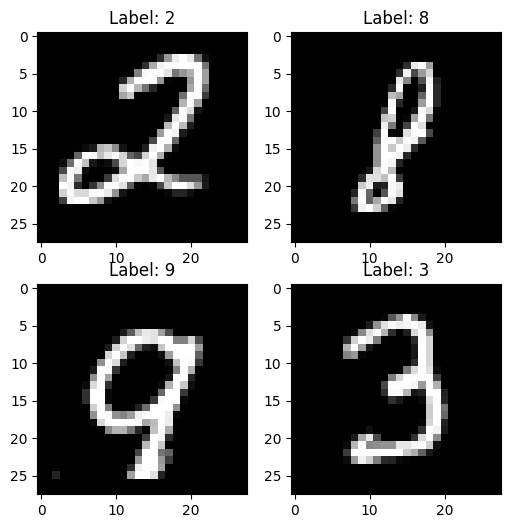

In [14]:
""" # must run previous cell block first before running this one again
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%Y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray')

Y_train = to_categorical(Y_train, num_classes=10)
Y_train = Y_train.reshape(Y_train.shape[0], 10, 1)
y_val = to_categorical(Y_train, num_classes=10)
y_test = to_categorical(Y_train, num_classes=10) """

In [4]:
seed = 42
low = -0.5
high = 0.5

rng = np.random.uniform(low, high, (784, 10))
print(str(rng.shape))
#rng.uniform(low, high, 784)


(784, 10)


In [ ]:
class Model():  
    def __init__(self, layers, epochs = 50):
        self.layers = layers
        self.epochs = epochs
        self.input = None
        self.a1 = None
        self.a2 = None

    def forward_propagate(self, input_data):
        output_layer1 = self.layers[0].forward_propagate(input_data)
        self.a1 = self.relu(output_layer1)
        output_layer2 = self.layers[1].forward_propagate(self.a1)
        self.a2 = self.sigmoid(output_layer2)
        return self.a2

    def relu(self, input):
        return np.maximum(0, input)

    def d_relu(self, input):
        return (input > 0).astype(float)
    
    # sigmoid function
    def sigmoid(self, z):
        return 1.0 / (1 + np.exp(-z))
    
    # derivative of sigmoid function
    def d_sigmoid(self, z):
        return self.sigmoid(z) * (1-self.sigmoid(z))
    
    def softmax(self, input):
        e = np.exp(input - input.max(axis=0, keepdims=True))
        return e / e.sum(axis=0, keepdims=True)
    
    def d_softmax(self, input): 
        jacobian_m = np.diag(input)
        for i in range(len(jacobian_m)):
            for j in range(len(jacobian_m)):
                if i == j:
                    jacobian_m[i][j] = input[i] * (1-input[i])
                else: 
                    jacobian_m[i][j] = -input[i] * input[j]
        return jacobian_m
    
    def Softmax_grad(self, x): # Best implementation (VERY FAST)
        '''Returns the Jacobian of the softmax function for the given set of inputs.
        Inputs:
        x: should be a 2d array where the rows correspond to the samples
            and the columns correspond to the nodes.
        Returns: jacobian
        '''
        s = self.softmax(x)
        a = np.eye(s.shape[-1])
        temp1 = np.zeros((s.shape[0], s.shape[1], s.shape[1]),dtype=np.float32)
        temp2 = np.zeros((s.shape[0], s.shape[1], s.shape[1]),dtype=np.float32)
        # Einsum is unsupported with Numba (nopython mode)
        # temp1 = np.einsum('ij,jk->ijk',s,a)
        # temp2 = np.einsum('ij,ik->ijk',s,s)
        for i in range(s.shape[0]):
            for j in range(s.shape[1]):
                for k in range(s.shape[1]):
                    temp1[i,j,k] = s[i,j]*a[j,k]
                    temp2[i,j,k] = s[i,j]*s[i,k]
        return temp1-temp2
    
    def mean_squared_error(self, y_true, y_pred):
        return np.mean(np.square(y_pred - y_true), axis=-1)

    def mse_loss_grad(self, y_true, y_pred):
        return 2*(y_pred-y_true)/y_pred.shape[1]
    
    def backward_propagate(self, learning_rate=0.01):
        derivative = self.d_sigmoid(self.a2)
        self.layers[1].backward_propagate(derivative, learning_rate=learning_rate)
        derivative = self.d_relu(self.a1)
        output = self.layers[0].backward_propagate(derivative, learning_rate=learning_rate)
        return output

    def train(self, X_train, Y_train):
        for epoch in range(self.epochs):
            total_loss = 0
            for x, y in zip(X_train, Y_train):
                x = x.reshape(x.shape[0], -1)
                y_pred = self.forward_propagate(x)

                loss = self.mean_squared_error(y, y_pred)
                total_loss += loss

                self.backward_propagate()

            if epoch % 100 == 0:
                print(f"Epoch {epoch + 1} out of {self.epochs}, loss: {total_loss / len(X_train)}")


class Dense():
    def __init__(self, m_input_size, n_output_size):
        self.input_size = m_input_size
        self.output_size = n_output_size
        self.inputs = None
        self.weights = np.random.uniform(-0.5, 0.5, (self.input_size, self.output_size))
        self.biases = np.zeros((1, output_size))
        self.dweights = np.random.uniform(-0.5, 0.5, (self.input_size, self.output_size))
        self.dbiases = np.zeros((1, output_size))

    def forward_propagate(self, input_data):
        self.inputs = input_data
        output = np.dot(input_data.T, self.weights)
        self.output = output.T + self.biases
        return self.output
    
    def backward_propagate(self, dvalues, learning_rate=0.01):
        self.dweights = np.dot(self.inputs, dvalues)
        self.dbiases = np.sum(dvalues, axis=0)

        # gradient on values
        self.dvalues = np.dot(dvalues, self.weights.T)

        # update weights
        self.weights -= learning_rate * self.weights
        self.biases -= learning_rate * self.biases
        return self.dvalues


input_size = 28 * 28
hidden_size = 128
output_size = 10

layer1 = Dense(784, 128)
layer2 = Dense(128, 10)
network = [layer1, layer2]
model = Model(network)
model.train(X_train, Y_train)

In [1]:
import numpy as np
import tensorflow
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import keras.losses
import keras.activations
import keras.layers
import tensorflow as tf


(X_train, Y_train), (x_test, y_test) = mnist.load_data()
X_train, Y_train = shuffle(X_train, Y_train)
X_train = X_train.astype('float32') / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)

import numpy as np

class Model():
    def __init__(self, layers, epochs=50):
        self.layers = layers
        self.epochs = epochs
        self.input = None
        self.a1 = None
        self.a2 = None

    def forward_propagate(self, input_data):
        output_layer1 = self.layers[0].forward_propagate(input_data)
        self.a1 = self.relu(output_layer1)
        output_layer2 = self.layers[1].forward_propagate(self.a1)
        self.a2 = output_layer2
        return self.a2

    def relu(self, input):
        return np.maximum(0, input)

    def d_relu(self, input):
        return (input > 0).astype(float)

    def mean_squared_error(self, y_true, y_pred):
        return np.mean(np.square(y_pred - y_true), axis=-1)

    def mse_loss_grad(self, y_true, y_pred):
        return 2 * (y_pred - y_true) / y_pred.shape[1]

    def backward_propagate(self, y_true, y_pred, learning_rate=0.01):
        derivative = self.mse_loss_grad(y_true, y_pred) * self.d_relu(self.a2)
        self.layers[1].backward_propagate(derivative, learning_rate=learning_rate)
        derivative = self.d_relu(self.a1)
        output = self.layers[0].backward_propagate(derivative, learning_rate=learning_rate)
        return output

    def train(self, X_train, Y_train):
        for epoch in range(self.epochs):
            total_loss = 0
            for x, y in zip(X_train, Y_train):
                y_pred = self.forward_propagate(x)
                loss = self.mean_squared_error(y, y_pred)
                total_loss += loss
                self.backward_propagate(y, y_pred)
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch + 1} out of {self.epochs}, loss: {total_loss / len(X_train)}")

class Dense():
    def __init__(self, m_input_size, n_output_size):
        self.input_size = m_input_size
        self.output_size = n_output_size
        self.inputs = None
        self.weights = np.random.uniform(-0.5, 0.5, (self.input_size, self.output_size))
        self.biases = np.zeros((1, self.output_size))
        
    def forward_propagate(self, input_data):
        self.inputs = input_data
        output = np.dot(input_data, self.weights) + self.biases
        return output

    def backward_propagate(self, output_gradient, learning_rate=0.01):
        self.inputs = self.inputs.reshape(-1, 1)

        weights_gradient = np.dot(self.inputs, output_gradient)
        biases_gradient = np.sum(output_gradient, axis=0, keepdims=True)
        input_gradient = np.dot(output_gradient, self.weights.T)
        self.weights -= learning_rate * weights_gradient
        self.biases -= learning_rate * biases_gradient
        return input_gradient


input_size = 28 * 28
hidden_size = 128
output_size = 10

layer1 = Dense(784, 128)
layer2 = Dense(128, 10)
network = [layer1, layer2]
model = Model(network)
model.train(X_train, Y_train)

Epoch 1 out of 50, loss: [8.45400413]
